In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

In [2]:
df_commute = pd.read_csv('data/commute_data.csv')

In [3]:
df_tracts = pd.read_csv('data/census_tracts_2010.csv')

In [19]:
df_commute.merge(df_tracts)

,OFIPS,DFIPS,OSTFIPS,OCTFIPS,OTRFIPS,DSTFIPS,DCTFIPS,DTRFIPS,FLOW,MOE,LENKM,ESTDIVMOE
0,6073018700,6073018700,6,73,18700,6,73,18700,20950,2359,0.000,8.88
1,51710000902,51710000902,51,710,902,51,710,902,10155,2516,0.000,4.04
2,45079011501,45079011501,45,79,11501,45,79,11501,8735,875,0.000,9.98
3,13215010802,13215010802,13,215,10802,13,215,10802,7720,1144,0.000,6.75
4,6071010402,6071010402,6,71,10402,6,71,10402,7040,848,0.000,8.30
5,12033002400,12033002400,12,33,2400,12,33,2400,6480,838,0.000,7.73
6,8041003802,8041003802,8,41,3802,8,41,3802,6380,583,0.000,10.94
7,36071013600,36071013600,36,71,13600,36,71,13600,5430,551,0.000,9.85
8,48029161400,48029161400,48,29,161400,48,29,161400,5410,909,0.000,5.95
9,17097863003,17097863003,17,97,863003,17,97,863003,5245,1069,0.000,4.91


In [4]:
df_commute = df_commute.head(1000)

In [5]:
df_pivot = df_commute.pivot(index='OFIPS', columns='DFIPS', values='FLOW')

In [6]:
df_pivot = df_pivot.fillna(0)

In [11]:
df_pivot.shape

(969, 878)

In [8]:
linkage_method = 'complete'
metric = 'cityblock'
distxy = squareform(pdist(df_pivot, metric=metric))

In [12]:
distxy.shape

(969, 969)

/Users/jonathanbate/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


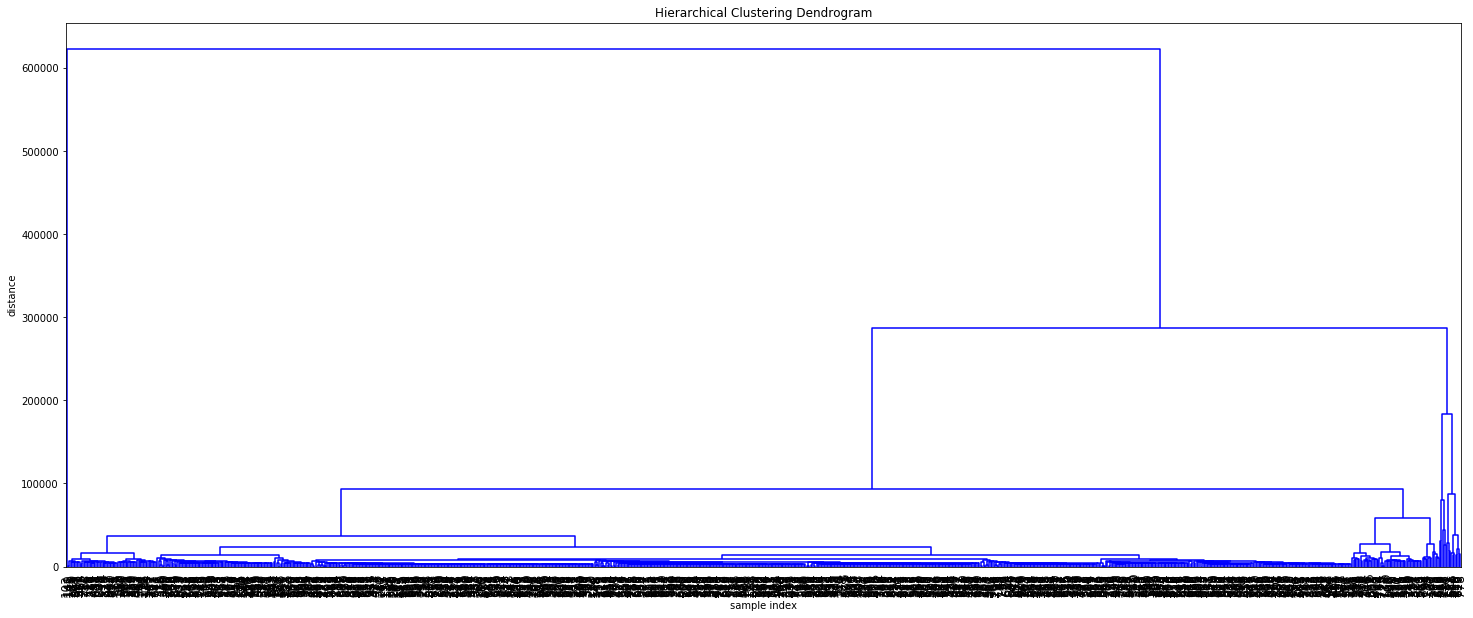

In [14]:
Z = linkage(distxy, linkage_method)
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    color_threshold = 20
)
plt.show()